In [1]:
%matplotlib inline


# Decoding with ANOVA + SVM: meditation vs hypnosis from the "phenoscores"

Decoding on the "phenoscores" (qualitative) dataset using a feature selection, followed by an SVM.


Phenomenological ressources/datasets can be found here : 

- https://docs.google.com/spreadsheets/d/1ZNLvdWQ74B0Zv7jMfsGiZqDjLri4G0FQBkKfmwiPmVM/edit#gid=1007273088
- https://docs.google.com/spreadsheets/d/1MDJi98qrE-xq7Ral0z9ZcmcfIM-15jmu/edit#gid=2065009937
- /home/romy.beaute/projects/hypnomed/analysis/pheno_stats/AL_analysis_V02.html

## Helpers functions

In [172]:
from scipy.io import loadmat


data_path = '/home/romy.beaute/projects/hypnomed/data'

def get_surf_emb(self,p):
    cortex = loadmat(os.path.join(p.data_path, 'cortex.mat'))
    cortex = cortex['cortex']
    surface_emb = np.zeros([self.emb.shape[0], 20484,len(p.dimension)])  # 20484 = nb of voxels for fsaverage5
    surface_emb[:, np.squeeze(cortex),:] = self.emb
    self.emb = surface_emb
    return self

## Retrieve the files of the Haxby dataset



In [2]:
from nilearn import datasets

# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
func_img = haxby_dataset.func[0]
# print basic information on the dataset
print('Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' %func_img)

Mask nifti image (3D) is located at: /home/romy.beaute/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /home/romy.beaute/nilearn_data/haxby2001/subj2/bold.nii.gz


## Load the behavioral data



In [3]:
import pandas as pd

# Load target information as string and give a numerical identifier to each

behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']

# Restrict the analysis to faces and places
from nilearn.image import index_img
condition_mask = behavioral['labels'].isin(['face', 'house'])
conditions = conditions[condition_mask]
func_img = index_img(func_img, condition_mask)

# Confirm that we now have 2 conditions
print(conditions.unique())

# The number of the session is stored in the CSV file giving the behavioral
# data. We have to apply our session mask, to select only faces and houses.
session_label = behavioral['chunks'][condition_mask]

['face' 'house']


In [93]:
df_pheno = pd.read_csv('/home/romy.beaute/projects/hypnomed/analysis/pheno_stats/questionnaires_hypnomed.csv').dropna()
outliers = ['15','27','32','40']
sublist = df_pheno.sub_id
phenodict_control = df_pheno.set_index('sub_id').to_dict()['phenoscore_control']
phenodict_meditation = df_pheno.set_index('sub_id').to_dict()['phenoscore_meditation']
phenodict_hypnosis = df_pheno.set_index('sub_id').to_dict()['phenoscore_hypnose']
df_G1 = df_pheno[df_pheno.version=='MH']
df_G2 = df_pheno[df_pheno.version=='HM']
sublist_G1 = df_G1.sub_id
sublist_G2 = df_G2.sub_id
df_pheno 

,sub_order,sub_name,sub_id,neucose_id,version,rs_run-1,rs_run-2,rs_run-3,MH,HM,phenoscore_control,phenoscore_meditation,phenoscore_hypnose
0,70,EH070,sub-01,NEUCOSE_ELSES07842,HM,control,hypnose,meditation,0,1,-0.285714,-0.571429,1.714286
1,87,LP087,sub-02,NEUCOSE_LECPA07862,MH,control,meditation,hypnose,1,0,-0.500000,-0.500000,0.500000
2,76,HM076,sub-03,NEUCOSE_HARMA07939,MH,control,meditation,hypnose,1,0,0.250000,0.000000,2.250000
3,43,BA043,sub-04,NEUCOSE_BUEAL07925,MH,control,meditation,hypnose,1,0,0.800000,-0.600000,0.200000
4,93,BA093,sub-05,NEUCOSE_BLUAL07960,HM,control,hypnose,meditation,0,1,0.500000,0.375000,-0.125000
5,91,MP091,sub-06,NEUCOSE_MANPA07927,MH,control,meditation,hypnose,1,0,-0.600000,-0.800000,1.600000
6,67,BL067,sub-07,NEUCOSE_BETLO07962,MH,control,meditation,hypnose,1,0,31.120000,0.166667,0.666667
7,21,GM021,sub-08,NEUCOSE_MAUGI07290,HM,control,hypnose,meditation,0,1,0.750000,0.750000,0.750000
8,29,NJ029,sub-09,NEUCOSE_NICJU06244,HM,control,hypnose,meditation,0,1,0.500000,-1.000000,-0.333333
11,64,FV064,sub-12,NEUCOSE_FEYVA07961,HM,control,hypnose,meditation,0,1,0.250000,0.500000,2.000000


In [136]:
hypnomed_csv = pd.read_csv('/home/romy.beaute/projects/hypnomed/analysis/pheno_stats/hypnomed.csv')
hypnomed_csv_withoutliers = hypnomed_csv.query('outlier == 0')
hypnomed_csv_G1 = hypnomed_csv_withoutliers.loc[hypnomed_csv_withoutliers['group']=='G1']
hypnomed_csv_G2 = hypnomed_csv_withoutliers.loc[hypnomed_csv_withoutliers['group']=='G2']


sublist_hypnomed = hypnomed_csv.query('outlier == 0')['sub_id'].tolist()
sublist_hypnomed_G1 = hypnomed_csv_G1['sub_id'].tolist()
sublist_hypnomed_G2 = hypnomed_csv_G2['sub_id'].tolist()
print('n = {} subjects in G1 / n = {} subjects in G2'.format(len(sublist_hypnomed_G1),len(sublist_hypnomed_G2)))


n = 18 subjects in G1 / n = 18 subjects in G2


0     G2
1     G1
2     G1
3     G1
4     G2
5     G1
6     G1
7     G2
8     G2
9     G1
10    G1
11    G2
12    G1
13    G1
15    G2
16    G1
17    G2
18    G1
19    G1
20    G2
21    G1
22    G2
23    G2
24    G2
25    G1
27    G1
28    G2
29    G2
30    G2
32    G2
33    G1
34    G2
35    G1
36    G2
37    G2
38    G1
Name: group, dtype: object

In [189]:
pd.read_csv('/home/romy.beaute/projects/hypnomed/analysis/pheno_stats/hypnomed.csv')

,sub_id,group,sub_name,neucose_id,version,rs_run-1,rs_run-2,rs_run-3,sub_order,block2_meditation,block3_meditation,outlier,outlier_phenoscores
0,sub-01,G2,EH070,NEUCOSE_ELSES07842,B,control,hypnose,meditation,70,0,1,0,0
1,sub-02,G1,LP087,NEUCOSE_LECPA07862,A,control,meditation,hypnose,87,1,0,0,0
2,sub-03,G1,HM076,NEUCOSE_HARMA07939,A,control,meditation,hypnose,76,1,0,0,0
3,sub-04,G1,BA043,NEUCOSE_BUEAL07925,A,control,meditation,hypnose,43,1,0,0,0
4,sub-05,G2,BA093,NEUCOSE_BLUAL07960,B,control,hypnose,meditation,93,0,1,0,0
5,sub-06,G1,MP091,NEUCOSE_MANPA07927,A,control,meditation,hypnose,91,1,0,0,0
6,sub-07,G1,BL067,NEUCOSE_BETLO07962,A,control,meditation,hypnose,67,1,0,0,0
7,sub-08,G2,GM021,NEUCOSE_MAUGI07290,B,control,hypnose,meditation,21,0,1,0,0
8,sub-09,G2,NJ029,NEUCOSE_NICJU06244,B,control,hypnose,meditation,29,0,1,0,0
9,sub-10,G1,BC082,NEUCOSE_BOLCL07876,A,control,meditation,hypnose,82,1,0,0,1


In [188]:
pd.read_pickle('/home/romy.beaute/projects/hypnomed/analysis/scripts_stats/data/composite_score.pkl')

,id,group,attentional_factor,constructive_factor,deconstructive_factor
21,25,exp,1.400936,1.524942,0.965556
22,26,nov,1.102868,-0.060134,0.389850
23,27,nov,0.592654,1.520855,0.173477
24,28,nov,-0.330921,-0.419319,-0.472394
25,29,nov,0.981388,1.157583,0.577418
26,30,nov,-1.426938,0.435126,-0.931946
27,32,nov,-0.141593,0.063681,0.138286
28,34,nov,0.349737,-1.026135,-0.475188
29,35,nov,-0.171728,0.802485,-0.588028
30,36,nov,0.632552,-0.902320,0.474268


In [194]:
b['subs']

array(['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06',
       'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
       'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18',
       'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24',
       'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30',
       'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36',
       'sub-37', 'sub-38', 'sub-39', 'sub-40'], dtype='<U6')

## Load the Hypnomed data (gradients)

In [18]:
import sys
sys.path.append('/home/romy.beaute/projects/hypnomed/META/')
from scipy.io import loadmat
from helpers_gradient import *

embmat_path = '/home/romy.beaute/projects/hypnomed/data/emb_matrices'
matfile = 'control_meditation_hypnose'
# emb = np.load(embmat_path+'/group_{}_embedding.mat'.format(matfile))

b,b_emb = load_embmat(embmat_path+'/group_{}_embedding.mat'.format(matfile),show_infos=True)
b_emb.shape


outliers_indxs = [15,27,32,40] #subject outliers (eg 'sub-15')
outliers_indxs_hyp = [15,27,39]
outliers = [x-1 for x in outliers_indxs] #index subject outliers (eg indx 14 to delete 'sub-15')
outliers_hyp = [x-1 for x in outliers_indxs_hyp]
# print(outliers,outliers_hyp)
# print('Subject removed (hypnose): ',outliers_hyp)

emb_con = np.delete(b_emb[:40],outliers,0)
emb_med = np.delete(b_emb[40:80],outliers,0)
emb_hyp = np.delete(b_emb[80:],outliers_hyp,0)

print(emb_con.shape,emb_med.shape,emb_hyp.shape)
embeddings = {
    'control':emb_con,
    'meditation':emb_med,
    'hypnose':emb_hyp
    }

emb_states = np.vstack([emb_con,emb_med,emb_hyp]) #embedding with all 3 states conditions
print(emb_states.shape) #control shape of the global embedding


emb_sublist = np.delete(b['subs'],[x-1 for x in outliers_indxs])
print('Redefining subject list after outlier removal : n_subjects = {} --> n_subjects = {}'.format(len(b['subs']),len(emb_sublist )))

 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

(36, 18715) (36, 18715) (36, 18715)
(108, 18715)


##  Recreate the behavioral (states conditions) data

In [143]:
n_subjects = len(emb_sublist)
print('n subjects = ',n_subjects)
# emb_sample = [f'sub-{i:02d}' for i in range(1, n_subjects + 1)]
emb_sample = emb_sublist.tolist()

labels = np.concatenate([([i]*n_subjects) for i in ['control','meditation','hypnosis']],axis=0)
subjects = emb_sample*3
sub_groups = hypnomed_csv_withoutliers['group'].tolist()*3

behavioral_hypnomed = pd.DataFrame(data={'labels':labels,'subjects':subjects,'group':sub_groups})
behavioral_hypnomed

n subjects =  36


,labels,subjects,group
0,control,sub-01,G2
1,control,sub-02,G1
2,control,sub-03,G1
3,control,sub-04,G1
4,control,sub-05,G2
...,...,...,...
103,hypnosis,sub-35,G2
104,hypnosis,sub-36,G1
105,hypnosis,sub-37,G2
106,hypnosis,sub-38,G2


In [144]:
states_to_compare = ['meditation','hypnosis']

conditions_hypnomed = behavioral_hypnomed['labels']
condition_mask_hypnomed = behavioral_hypnomed['labels'].isin([states_to_compare[0],states_to_compare[1]])
conditions_hypnomed = conditions_hypnomed[condition_mask_hypnomed]
print(conditions_hypnomed.unique()) #confirm that we kept the 2 conditions corresponding to the states we want to compare

session_label_hypnomed = behavioral_hypnomed['subjects'][condition_mask_hypnomed]
session_label_hypnomed

['meditation' 'hypnosis']


36     sub-01
37     sub-02
38     sub-03
39     sub-04
40     sub-05
        ...  
103    sub-35
104    sub-36
105    sub-37
106    sub-38
107    sub-39
Name: subjects, Length: 72, dtype: object

## Reconstruction design matrix and behavioral conditions hypnomed (visualisation purpose)

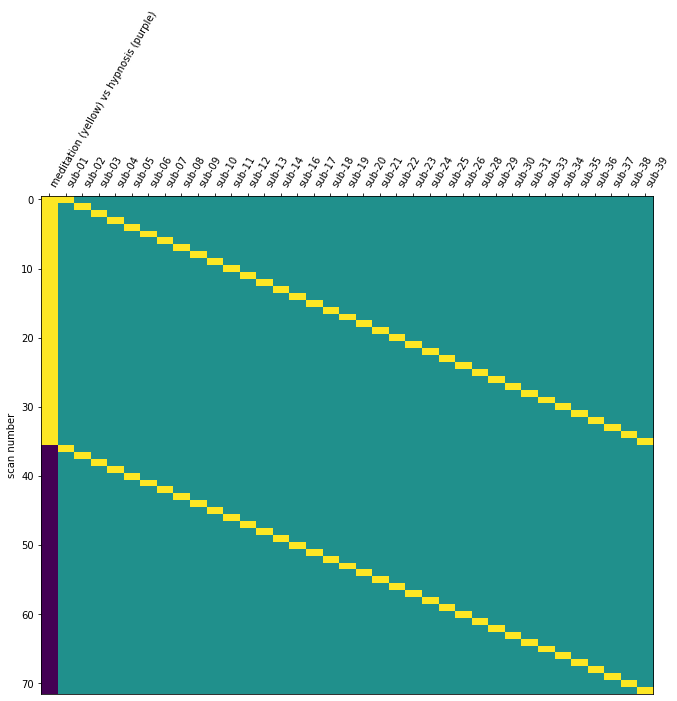

In [145]:
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import plot_design_matrix



#Triple effect : control vs meditation vs hypnose
condition_effect_triple = np.hstack(([1] * n_subjects, [2] * n_subjects, [3] * n_subjects))
subject_effect_triple = np.vstack((np.eye(n_subjects), np.eye(n_subjects),np.eye(n_subjects)))
paired_design_matrix_triple = pd.DataFrame(
    np.hstack((condition_effect_triple[:, np.newaxis], subject_effect_triple)),
    columns=['Control (blue) vs Meditation (green) vs Hypnose (yellow)'] + emb_sample)

#Double effect : control vs meditation vs hypnose
condition_effect_double = np.hstack(([1] * n_subjects, [-1] * n_subjects))
subject_effect_double = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
paired_design_matrix_double = pd.DataFrame(
    np.hstack((condition_effect_double[:, np.newaxis], subject_effect_double)),
    columns=['{} (yellow) vs {} (purple) '.format(states_to_compare[0],states_to_compare[1])] + emb_sample)


design_matrix = paired_design_matrix_double if len(states_to_compare)<3 else paired_design_matrix_triple

#_, (ax_paired) = plt.subplots(1,1, gridspec_kw={'width_ratios': [1, 17]})
plot_design_matrix(design_matrix, rescale=False)#, ax=ax_paired)
#ax_paired.set_title('paired design', fontsize=12)
#plt.set_title('paired design', fontsize=12)
plt.tight_layout()
plotting.show()


## ANOVA pipeline with :class:`nilearn.decoding.Decoder` object

Nilearn Decoder object aims to provide smooth user experience by acting as a
pipeline of several tasks: preprocessing with NiftiMasker, reducing dimension
by selecting only relevant features with ANOVA -- a classical univariate
feature selection based on F-test, and then decoding with different types of
estimators (in this example is Support Vector Machine with a linear kernel)
on nested cross-validation.



In [157]:
from nilearn.decoding import Decoder
# Here screening_percentile is set to 5 percent
mask_img = haxby_dataset.mask
decoder = Decoder(estimator='svc', mask=mask_img, smoothing_fwhm=4,
                  standardize=True, screening_percentile=5, scoring='accuracy')

decoder_hypnomed = Decoder(estimator='svc', mask='gm_template',smoothing_fwhm=4,
                  standardize=True, screening_percentile=5, scoring='accuracy')

### Project embedding data on cortex

In [187]:
data_path = '/home/romy.beaute/projects/hypnomed/data'
cortex = loadmat(os.path.join(data_path, 'cortex.mat'))
cortex = cortex['cortex']

surface_emb = np.zeros([emb_states.shape[0], 20484])  # 20484 = nb of voxels for fsaverage5
surface_emb[:, np.squeeze(cortex)] = emb_states


## Fit the decoder and predict



In [161]:
decoder.fit(func_img, conditions)
y_pred = decoder.predict(func_img)

In [170]:
np.array([1, 2000, 7], dtype="int32").shape

(3,)

## Obtain prediction scores via cross validation
Define the cross-validation scheme used for validation. Here we use a
LeaveOneGroupOut cross-validation on the session group which corresponds to a
leave a session out scheme, then pass the cross-validator object to the cv
parameter of decoder.leave-one-session-out For more details please take a
look at:
[Measuring prediction scores using cross-validation\](../00_tutorials/plot_decoding_tutorial.html#measuring-prediction-scores-using-cross-validation)



In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
cv = LeaveOneGroupOut()

decoder = Decoder(estimator='svc', mask=mask_img, standardize=True,
                  screening_percentile=5, scoring='accuracy', cv=cv)
# Compute the prediction accuracy for the different folds (i.e. session)
decoder.fit(func_img, conditions, groups=session_label)

# Print the CV scores
print(decoder.cv_scores_['face'])

## Visualize the results
Look at the SVC's discriminating weights using
:class:`nilearn.plotting.plot_stat_map`



In [ ]:
weight_img = decoder.coef_img_['face']
from nilearn.plotting import plot_stat_map, show
plot_stat_map(weight_img, bg_img=haxby_dataset.anat[0], title='SVM weights')

show()

Or we can plot the weights using :class:`nilearn.plotting.view_img` as a
dynamic html viewer



In [ ]:
from nilearn.plotting import view_img
view_img(weight_img, bg_img=haxby_dataset.anat[0],
         title="SVM weights", dim=-1)

Saving the results as a Nifti file may also be important



In [ ]:
weight_img.to_filename('haxby_face_vs_house.nii')